In [111]:
import math

import pandas as pd
import seaborn as sns
from glob import glob
from datetime import datetime
import math

In [93]:
dfs = []
previous_columns = set()
for filename in sorted(glob("data/green500_top_*.xlsx")):
    print(f"\n\n# reading {filename}")
    d = datetime.strptime(filename, "data/green500_top_%Y%m.xlsx")
    df1 = pd.read_excel(filename)
    df1 = df1.rename(columns={
        "How?": "Power Source",
        "how": "Power Source",
        "proc_frequency": "Proc_Frequency",
        "operating_system": "Operating System",
        "OS": "Operating System",
        "top500_rank": "Top500_Rank",
        "green500_rank": "Green500_Rank",
        "system_family": "System Family",
        "processor_family": "Processor Technology",
        "Processor_Family": "Processor Technology",
        "Proc_Frequency": "Processor Speed (MHz)",
        "proc_frequency": "Processor Speed (MHz)",
        "Rpeak": "RPeak",
        "Power": "Power (kW)",
        "total_power": "Power (kW)",
        "mflops_per_watt": "Mflops/Watt",
        "Power Effeciency [GFlops/Watts]": "Energy Efficiency [GFlops/Watts]",
        "Power Efficiency [GFlops/Watts]": "Energy Efficiency [GFlops/Watts]",
    })
    df1 = df1.drop(columns=["Unnamed: 18",
                            "Top500_Previous_Rank", "Green500_Previous_Rank", "Rank", "First Rank", "First Appearance", "Previous Rank", "Notes", "Green500_Rank", "Top500_Rank", "TOP500 Rank",
                            "name", "Name", "Computer",
                            ], errors="ignore")
    if "Mflops/Watt" in df1.columns:
        df1["Mflops/Watt"] = df1["Mflops/Watt"] / 1000
        df1 = df1.rename(columns={
            "Mflops/Watt": "Energy Efficiency [GFlops/Watts]"
        })
    if "RPeak" in df1.columns:
        df1["RPeak"] = df1["RPeak"] / 1000
        df1 = df1.rename(columns={
            "RPeak": "Rpeak [TFlop/s]"
        })
    if "Rmax" in df1.columns:
        df1["Rmax"] = df1["Rmax"] / 1000
        df1 = df1.rename(columns={
            "Rmax": "Rmax [TFlop/s]"
        })

    columns = set(df1.columns)
    assert "Mflops/Watt" not in columns
    if columns != previous_columns:
        print(f"new columns: {columns - previous_columns}")
        print(f"removed columns: {previous_columns - columns}")
        previous_columns = columns

    try:
        df1["Power Quality Level"] = df1["Power Quality Level"].where(lambda x: x != 0).dropna()
    except KeyError:
        pass
    df1["list"] = d
    # df1 = df1[sorted(df1.columns.tolist())]
    dfs.append(df1)

df = pd.concat(dfs, ignore_index=True)
df = df.drop_duplicates(["Energy Efficiency [GFlops/Watts]", "Power (kW)"], keep='first', ignore_index=True)



# reading data/green500_top_201311.xlsx
new columns: {'Processor Technology', 'Rmax [TFlop/s]', 'Region', 'Rpeak [TFlop/s]', 'System Model', 'Processor', 'Accelerator/Co-Processor', 'Interconnect Family', 'Cores per Socket', 'Interconnect', 'Site', 'Manufacturer', 'Operating System', 'Power (kW)', 'Architecture', 'System Family', 'Processor Speed (MHz)', 'Continent', 'OS Family', 'Country', 'Nmax', 'Total Cores', 'Processor Generation', 'Energy Efficiency [GFlops/Watts]', 'Year', 'Accelerator/Co-Processor Cores', 'Segment', 'Power Source'}
removed columns: set()


# reading data/green500_top_201406.xlsx
new columns: {'Nhalf'}
removed columns: set()


# reading data/green500_top_201411.xlsx


/home/tilsche/.cache/pypoetry/virtualenvs/green500-analysis-AyUEgljv-py3.11/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)




# reading data/green500_top_201506.xlsx


# reading data/green500_top_201511.xlsx


# reading data/green500_top_201606.xlsx


# reading data/green500_top_201611.xlsx


# reading data/green500_top_201706.xlsx
new columns: {'Optimized Run (Peak Power)', 'Power Quality Level', 'Measured Cores', 'Optimized Run (HPL)', 'Power Source.1'}
removed columns: {'Nmax', 'Nhalf'}


# reading data/green500_top_201711.xlsx
new columns: {'System ID', 'Site ID'}
removed columns: set()


# reading data/green500_top_201806.xlsx


# reading data/green500_top_201811.xlsx


# reading data/green500_top_201906.xlsx


# reading data/green500_top_201911.xlsx


# reading data/green500_top_202006.xlsx
new columns: set()
removed columns: {'Region'}


# reading data/green500_top_202011.xlsx
new columns: set()
removed columns: {'Measured Cores'}


# reading data/green500_top_202106.xlsx
new columns: {'Memory'}
removed columns: set()


# reading data/green500_top_202111.xlsx


# reading data/green500_top_202206.xlsx

In [94]:
df = df.dropna(subset=["Energy Efficiency [GFlops/Watts]"])
df["ee_manual"] = df["Rmax [TFlop/s]"] / df["Power (kW)"]
df["ee_discrepancy"] = df["ee_manual"] / df["Energy Efficiency [GFlops/Watts]"]
# Soo many inconsistent numbers :{
df = df[df["ee_discrepancy"] > 0.6]
df = df[df["ee_discrepancy"] < 1.1]

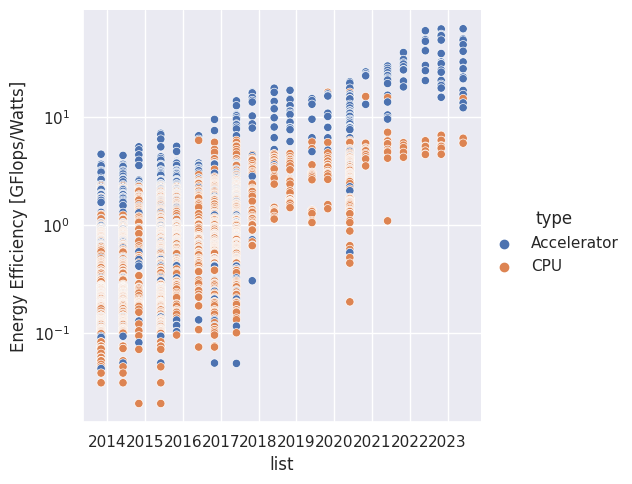

In [135]:
df["type"] = df["Accelerator/Co-Processor"].apply(lambda x: "CPU" if isinstance(x, float) else "Accelerator")
fg = sns.relplot(data=df, y="Energy Efficiency [GFlops/Watts]", x='list', hue="type")
# log y-scale
fg.ax.set_yscale("log")

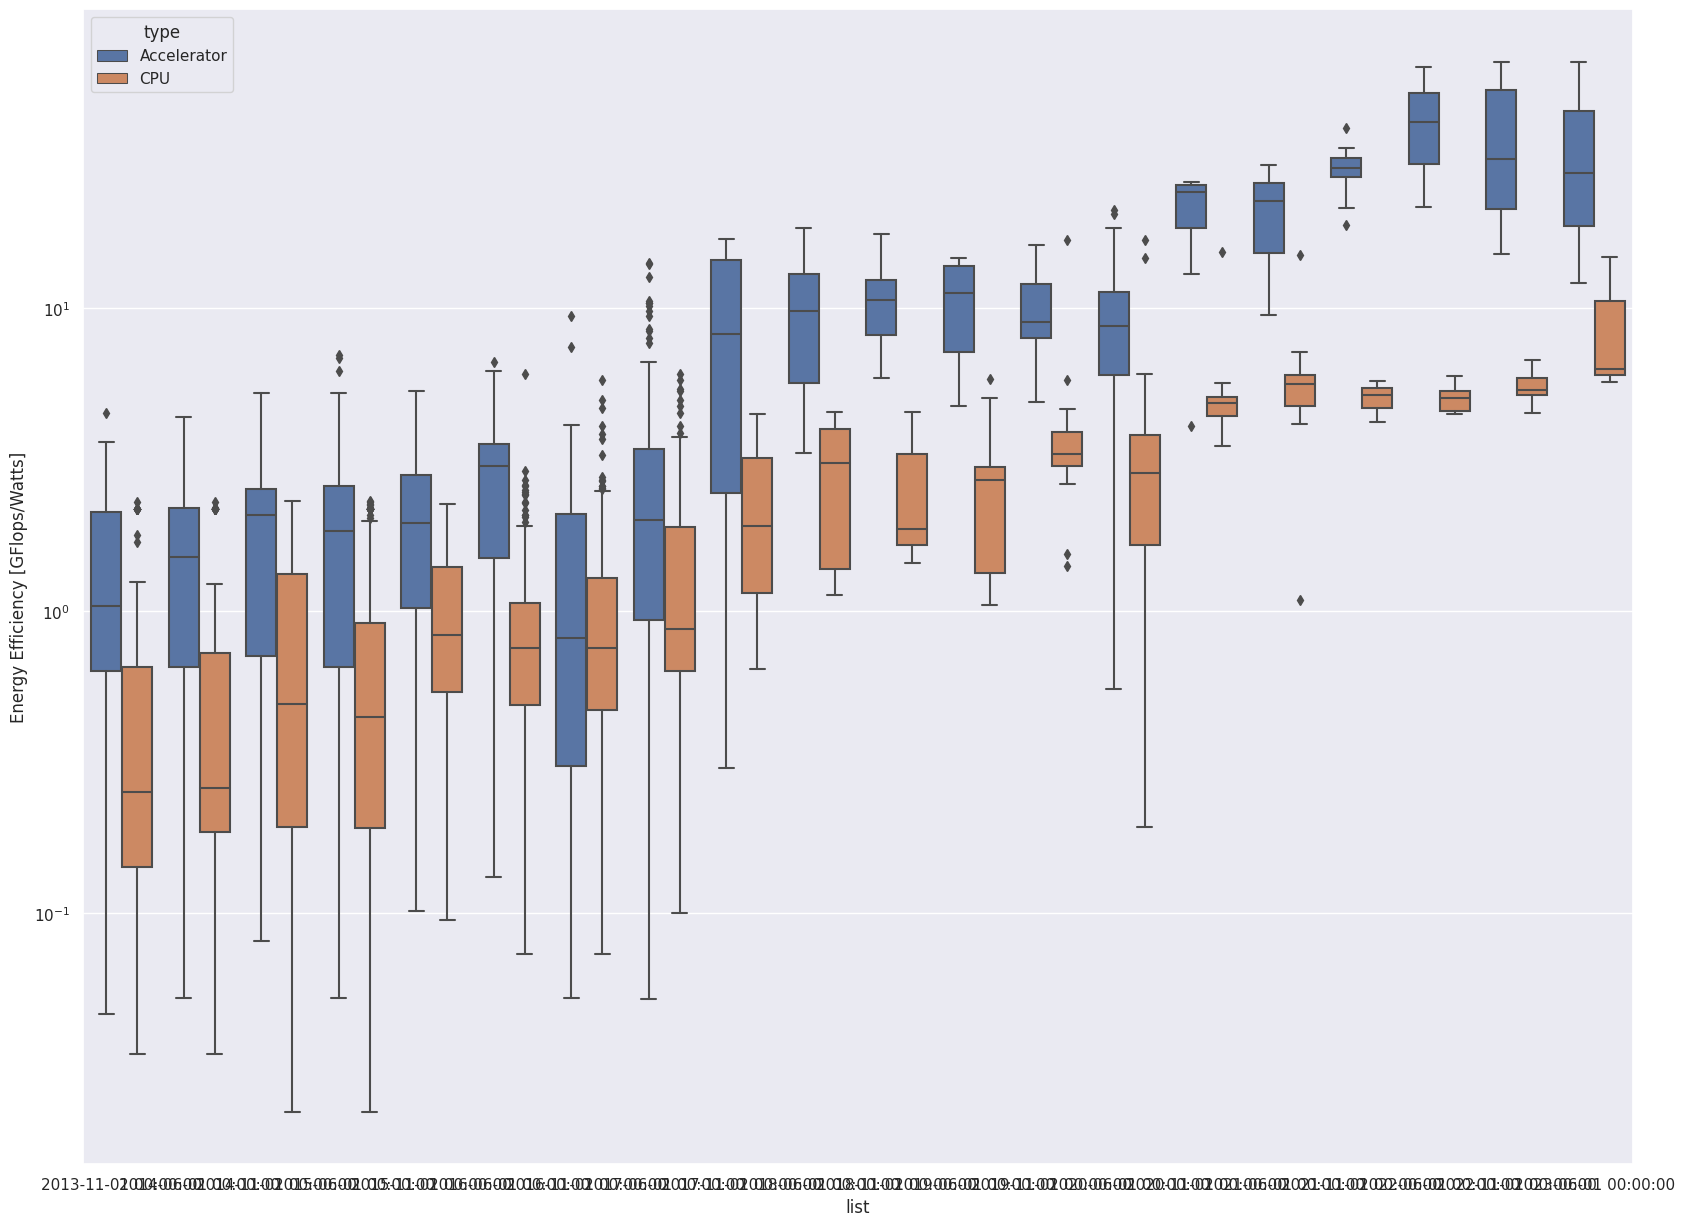

In [132]:
sns.set(rc={'figure.figsize': (20, 15)})
df["type"] = df["Accelerator/Co-Processor"].apply(lambda x: "CPU" if isinstance(x, float) else "Accelerator")
ax = sns.boxplot(data=df, y="Energy Efficiency [GFlops/Watts]", x='list', hue="type")
# log y-scale
ax.set_yscale("log")

In [134]:
what = df[df["type"] == "CPU"]